<a href="https://colab.research.google.com/github/Ayazdani1997/stock-feature-prediction-final-pro/blob/master/Phase1_OCHLV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pandas
!pip install tensorflow
!pip install tensorflow-gpu

In [4]:
pip install --upgrade tensorflow-gpu

Requirement already up-to-date: tensorflow-gpu in /usr/local/lib/python3.6/dist-packages (2.2.0)


In [0]:
import tensorflow

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives
from tensorflow.keras import optimizers


import pandas
import matplotlib.pyplot as plt
# from google.colab import drive
from os.path import join
import numpy

ROOT = '/content/drive'

In [7]:
from google.colab import drive

drive.mount(ROOT)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
HOME = join(ROOT, 'My\ Drive')
PROJECT = join(HOME, 'Undergraduate_Final_Project')
zip_archive = join(PROJECT, 'data.zip')
!ls $PROJECT
zip_archive = join(join(HOME, 'Undergraduate_Final_Project'), 'data.zip')
!unzip $zip_archive -d .

 data.zip	    'Publications Notes'
 Features	    'Stock Notes'
 Implementation      Stock_Publications.gdoc
 Operational.ipynb   Undergrad_Final_Project_ProgressLine.gdoc
Archive:  /content/drive/My Drive/Undergraduate_Final_Project/data.zip
replace ./data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [0]:
data = pandas.read_csv('data.csv', encoding='utf-16')

In [0]:
data = data.drop(['Unnamed: 0', 'VAL', 'NUM_OF_TRANSACTIONS','CLOSE_ONE_DAY_BEFORE'], axis=1).rename(columns={'DTYYYYMMDD': 'DATE'})
data['DATE'] = pandas.to_datetime(data['DATE'],format='%Y%m%d')

In [11]:
labels = pandas.DataFrame()
labels['CLASS'] = numpy.where(data['CLOSE'] > data['CLOSE'].shift(1), 1.0, 0.0)
labels['DATE'] = data['DATE'].copy()
labels['TICKER'] = data['TICKER'].copy()
labels.head(10)

,CLASS,DATE,TICKER
0,0.0,2019-11-20,مظنه
1,0.0,2019-11-23,مظنه
2,0.0,2019-11-24,مظنه
3,0.0,2019-11-25,مظنه
4,0.0,2019-11-26,مظنه
5,0.0,2019-11-27,مظنه
6,0.0,2019-11-30,مظنه
7,0.0,2019-12-01,مظنه
8,0.0,2019-12-02,مظنه
9,0.0,2019-12-03,مظنه


Let's assert if we are using GPU.

In [12]:
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [0]:
physical_devices = tensorflow.config.list_physical_devices('GPU')
tensorflow.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [0]:
import matplotlib.dates as mdates

def draw_ochlv(data_related_to_stock, from_date, to_date):
    fig, axs = plt.subplots(3, 2, sharex=True, figsize=(10,10))
    fig.tight_layout()

    
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    years_fmt = mdates.DateFormatter('%Y')

    axs[0][0].xaxis.set_major_locator(years)
    axs[0][0].xaxis.set_major_formatter(years_fmt)
    axs[0][0].xaxis.set_minor_locator(months)

    mask = (data_related_to_stock['DATE'] >= from_date) & (data_related_to_stock['DATE'] <= to_date ) 
    period = data_related_to_stock.loc[mask]
    
    starting_date = str(from_date)
    ending_date = str(to_date)

    axs[0][0].plot(period['DATE'], period['CLOSE'])
    axs[0][0].set(ylabel='closing price (in tomans)')
    axs[0][0].set_title('closing price')
    
    axs[1][0].plot(period['DATE'], period['OPEN'])
    axs[1][0].set(ylabel='opening price (in tomans)')
    axs[1][0].set_title('opening price')
                     
    
    axs[0][1].plot(period['DATE'], period['VOL'])
    axs[0][1].set(ylabel='daily volume traded (in share)')
    axs[0][1].set_title('daily volume')
                     
    
    axs[1][1].plot(period['DATE'], period['HIGH'])
    axs[1][1].set(ylabel='high price (in tomans)')
    axs[1][1].set_title('high price')
                     
    axs[2][0].plot(period['DATE'], period['LOW'])
    axs[2][0].set(ylabel='low price (in tomans)')
    axs[2][0].set_title('low price')

    axs[0][0].grid(True)
    axs[0][1].grid(True)
    axs[1][0].grid(True)
    axs[1][1].grid(True)
    axs[2][0].grid(True)

    axs[0][0].format_xdata = mdates.DateFormatter('%Y-%m-%d')

    plt.show()

In [15]:
ten_stocks_with_max_trading_days = data.groupby('TICKER').agg({'DATE': ['min', 'max', 'count'], 'VOL': ['mean']}).reset_index().sort_values(('DATE', 'count'), ascending=False).head(10)
stock_with_max_trading_days = ten_stocks_with_max_trading_days['TICKER'].iloc[0]
ten_stocks_with_max_trading_days.head(10)

TICKER       DATE                            VOL
                   min        max count          mean
1616  وپترو 2001-03-25 2020-04-13  4366  2.323352e+06
1522  وساخت 2001-03-25 2020-04-13  4356  1.464725e+06
56    آريان 2010-10-06 2020-04-13  4347  2.723661e+06
624   خودرو 2001-03-25 2020-04-13  4340  1.123416e+07
1539   وسپه 2001-03-27 2020-04-13  4323  2.620691e+06
753   زنجان 2011-01-05 2020-04-13  4318  9.637195e+05
567   خبهمن 2001-04-07 2020-04-13  4315  6.061205e+06
1603  ونيكي 2001-04-07 2020-04-13  4302  1.712802e+06
900   شاراك 2001-03-27 2020-04-13  4298  2.342162e+06
1474  وبشهر 2001-03-25 2020-04-13  4291  2.265908e+06

## Train Routines

In [0]:

class MyNormalizer:
  def __init__(self):
    self.max = 0
    self.min = 0

  def fit(self, data):
    self.max = data.max()
    self.min = data.min()
  
  def transform(self, data):
    return (data - self.min) / (self.max - self.min)


def align_data(x, y, window_in_days, batch_size):
  rows_to_insert_to_x = pandas.DataFrame(numpy.zeros((window_in_days+(batch_size - len(x) % batch_size),\
                                                      len(x.columns))), columns=x.columns)
  rows_to_insert_to_y = pandas.DataFrame(numpy.zeros(\
                                                     (window_in_days+(batch_size - len(x) % batch_size), \
                                                      len(y.columns))), columns=y.columns)

  return pandas.concat([rows_to_insert_to_x, x], ignore_index=True), \
        pandas.concat([rows_to_insert_to_y, y], ignore_index=True)
  

def split_data_to_train_test(original_dataset, labels, stock, \
                             training_start, training_end, testing_start, testing_end, \
                             test_required=True, drop_date=True):
  data_related_to_stock = original_dataset[ original_dataset['TICKER'] == stock ].drop('TICKER', axis=1)
  labels_related_to_stock = labels[ labels['TICKER'] == stock ].drop('TICKER', axis=1)

 
  training_period_mask = (data_related_to_stock['DATE'] >= training_start) \
    & (data_related_to_stock['DATE'] <= training_end ) 
  training_period = data_related_to_stock.loc[training_period_mask]
  if drop_date:
        training_period = training_period.drop('DATE', axis=1)
  training_period_labels = labels_related_to_stock.loc[training_period_mask]
  if drop_date:
        training_period_labels = training_period_labels.drop('DATE', axis=1)

  testing_period = None
  testing_period_labels = None
  if test_required:
    testing_period_mask = (data_related_to_stock['DATE'] >= testing_start) \
        & (data_related_to_stock['DATE'] <= testing_end )
    testing_period = data_related_to_stock.loc[testing_period_mask]
    if drop_date:
        testing_period = testing_period.drop('DATE', axis=1)
    testing_period_labels = labels_related_to_stock.loc[testing_period_mask]
    if drop_date:
        testing_period_labels = testing_period_labels.drop('DATE', axis=1)

  return training_period, training_period_labels , testing_period, testing_period_labels


def normalize_dataframe_with_max_min(dataframe, train_max, train_min):
    normalized_df=(dataframe - train_min)/(train_max - train_min)
    return normalized_df



In [0]:
def generate_datasets_for_model(original_dataset, labels, stock, training_start, training_end, \
                                testing_start, testing_end, window_in_days=10, batch_size=32, test_required=True):
  normalizer = MyNormalizer()
  training_data = []
  training_labels = []
  testing_data = []
  testing_labels = []

  training_period, training_period_labels, testing_period, testing_period_labels \
    = split_data_to_train_test(original_dataset, labels, stock, training_start, training_end \
                                , testing_start, testing_end, test_required, True)


  training_period, training_period_labels = align_data(training_period, \
                                                       training_period_labels, window_in_days, batch_size)

  if test_required:
    testing_period, testing_period_labels = align_data(testing_period, \
                                                       testing_period_labels, window_in_days, batch_size)                                                                                               

  normalizer.fit(training_period)
  training_period = normalizer.transform(training_period)

  for j in range(window_in_days, len(training_period)):
    training_data.append(numpy.array(training_period[ j - window_in_days : j ].copy()))
    training_labels.append(numpy.array(training_period_labels.iloc[j]))

  training_data = numpy.array(training_data)
  training_labels = numpy.array(training_labels)

  if test_required:
    testing_period = normalizer.transform(testing_period)
    for j in range(window_in_days, len(testing_period)):
      testing_data.append(numpy.array(testing_period[ j - window_in_days : j ].copy()))
      testing_labels.append(numpy.array(testing_period_labels.iloc[j]))

  testing_data = numpy.array(testing_data)
  testing_labels = numpy.array(testing_labels)

  train_generator = DataGenerator(training_data, training_labels, batch_size=batch_size)
  test_generator = DataGenerator(testing_data, testing_labels, batch_size=batch_size)

  return train_generator, test_generator



In [0]:
class DataGenerator(tensorflow.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, labels, batch_size=32):
        'Initialization'
        self.data = data
        self.dim = data.shape
        self.batch_size = batch_size
        self.labels = labels
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(numpy.floor(self.dim[0] / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        
        x = self.data[index * self.batch_size: (index + 1) * self.batch_size]

        y = self.labels[index * self.batch_size: (index + 1) * self.batch_size]
        
        return x, y

    def on_epoch_end(self):
        pass

In [0]:

def build_model(input_shape, optimizer='adam', layers=None, loss='binary_crossentropy', metrics=[BinaryAccuracy(name='accuracy')]):
  if layers is None:
    model = Sequential()
    model.add(LSTM(64, input_shape=(input_shape[1], input_shape[2])))
    model.add(Dense(32))
    model.add(Dropout(0.1))
    model.add(Dense(16))
    model.add(BatchNormalization())
    model.add(Dense(4))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

  else:
    model = Sequential(layers)
  
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)


  return model


In [0]:
from tensorflow.keras.callbacks import ProgbarLogger
from tensorflow.keras.callbacks import Callback
from datetime import datetime

class MyLogger(Callback):
    def __init__(self, verbose, count_mode='samples'):
        # Ignore the `verbose` argument specified in `fit()` and pass `count_mode` upstream
        self.verbose = verbose
        self.metrics = ['loss', 'accuracy']
        self.epoch_start = 0
        self.epoch_finish = 0

    def on_train_begin(self, logs=None):
        pass

    def on_epoch_begin(self, epoch, logs=None):
        self.params['metrics'] = self.metrics
        self.epochs = self.params['epochs']
        if self.verbose:
            print('----------->> Epoch %d/%d' % (epoch + 1, self.epochs), end='   ')
        self.epoch_start = datetime.now()

    def on_batch_begin(self, batch, logs=None):
        pass

    def on_batch_end(self, batch, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_finish = datetime.now()
        duration = (self.epoch_finish - self.epoch_start).total_seconds()
        print('%.3f seconds' % (duration), end=' , ')
        self.log_values = []
        logs = logs or {}
        for k in self.params['metrics']:
            if k in logs:
                self.log_values.append((k, logs[k]))
        if self.verbose:
            for metric, value in self.log_values:
              print('%s : %.3f' % ( metric, value), end='    ')
        print()
    
    def on_train_end(self, logs=None):
        pass


In [0]:
# results is in form of [loss, acc, true positives, false positives, true negatives, false negatives]
def calc_pos_neg_rate(results):
  new_results = {}
  new_results['loss'] = results[0] # loss
  new_results['acc'] = results[1] # accuracy
  new_results['true_positive_rate'] = (results[2]) / (results[2] + results[5]) # true positive rate
  new_results['false_positive_rate'] = (results[3]) / (results[3] + results[4]) # false positive rate
  new_results['positive_precision'] = (results[2]) / (results[2] + results[3]) # positive precision
  new_results['negative_precision'] = (results[4]) / (results[4] + results[5]) # negative precision
  return new_results

In [0]:
def tabular_test_train_results(train_generator, test_generator, train_results, test_results, batch_size=32):
    rows = ['train', 'test']
    columns = [metric for metric in test_results]
    columns.append('set_size')
    table_data = [ [str(train_results[metric]) for metric in train_results],\
            [str(test_results[metric]) for metric in test_results]]
    table_data[0].append(len(train_generator) * batch_size)
    table_data[1].append(len(test_generator) * batch_size)
    table = plt.table(cellText=table_data,
                      rowLabels=rows,
                      colLabels=columns,
                      cellLoc='center',
                      loc='center',
                      rowLoc='center',
                      )
    plt.axis('off')
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(2, 8)
    plt.show()

In [0]:
def fit(model, epochs, train_generator):
  train_losses = []

  train_accs = []

  for i in range(epochs):
      print('epoch %d' % (i + 1))
      history = model.fit(x=train_generator,
                        epochs=1,
                        verbose=0,
                        callbacks=[MyLogger(1)]
                        )
      train_accs.append(history.history['accuracy'])
      train_losses.append(history.history['loss'])
      model.reset_states() 
  return train_accs, train_losses

## **Stateful LSTM**

In this section, we train our model on the stock with max trading days. first of all, let's visualize the whole market to investigate the oscilations of price.

In [0]:
data_related_to_max_stock = data[ data['TICKER'] == stock_with_max_trading_days ]

In [0]:
training_start = pandas.to_datetime('20080101', format='%Y%m%d', errors='ignore')
training_end = pandas.to_datetime('20170919', format='%Y%m%d', errors='ignore')
testing_start = pandas.to_datetime('20180101', format='%Y%m%d', errors='ignore')
testing_end = pandas.to_datetime('20180719', format='%Y%m%d', errors='ignore')

In [0]:
start_period = pandas.to_datetime('20010101', format='%Y%m%d', errors='ignore')
end_period = pandas.to_datetime('20200414', format='%Y%m%d', errors='ignore')

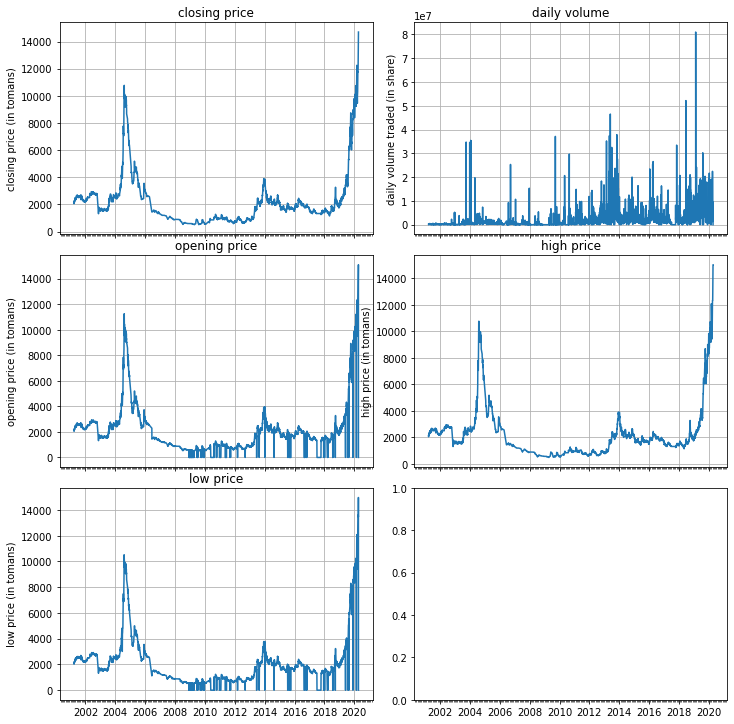

In [0]:
draw_ochlv(data_related_to_max_stock, start_period, end_period)

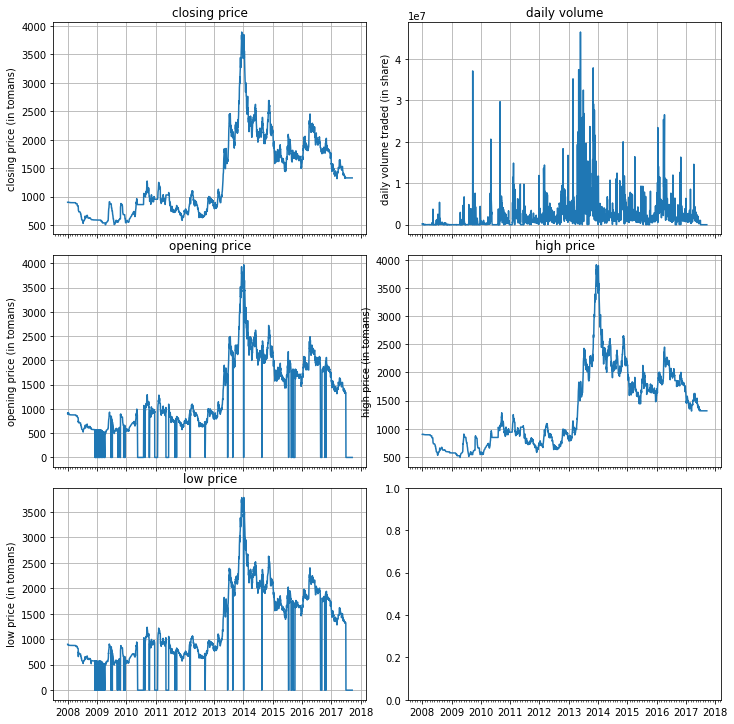

In [0]:
draw_ochlv(data_related_to_max_stock, training_start, training_end)

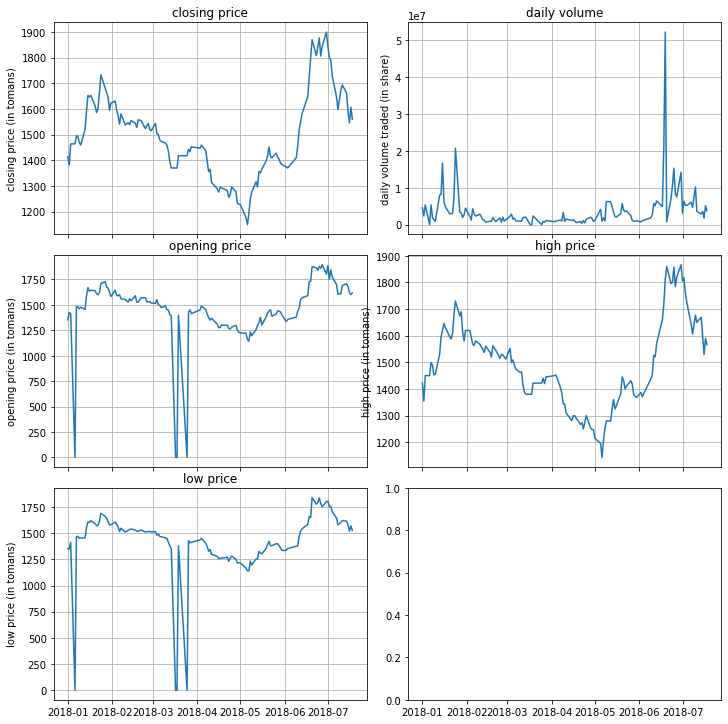

In [0]:
draw_ochlv(data_related_to_max_stock, testing_start, testing_end)

Now, let's apply alignment and normalization on both sets and see the range of data. The batch size is 32 and window length is 10.

In [0]:
normalizer = MyNormalizer()

training_period, training_labels, testing_period, testing_labels \
    = split_data_to_train_test(data, labels, \
                               stock_with_max_trading_days, training_start, training_end \
                                , testing_start, testing_end, True, False)

training_period, _ = align_data(training_period, \
                                                       training_labels, 10, 32)

testing_period, _ = align_data(testing_period, \
                                                       testing_labels, 10, 32)
training_date = training_period['DATE']
testing_date = testing_period['DATE']

_training_period = training_period.drop('DATE', axis=1)
_testing_period = testing_period.drop('DATE', axis=1)

normalizer.fit(_training_period)
_training_period = normalizer.transform(_training_period)
_testing_period = normalizer.transform(_testing_period)
_training_period['DATE'] = training_date.reset_index(drop=True).replace(0, numpy.nan)
_testing_period['DATE'] = testing_date.reset_index(drop=True).replace(0, numpy.nan)

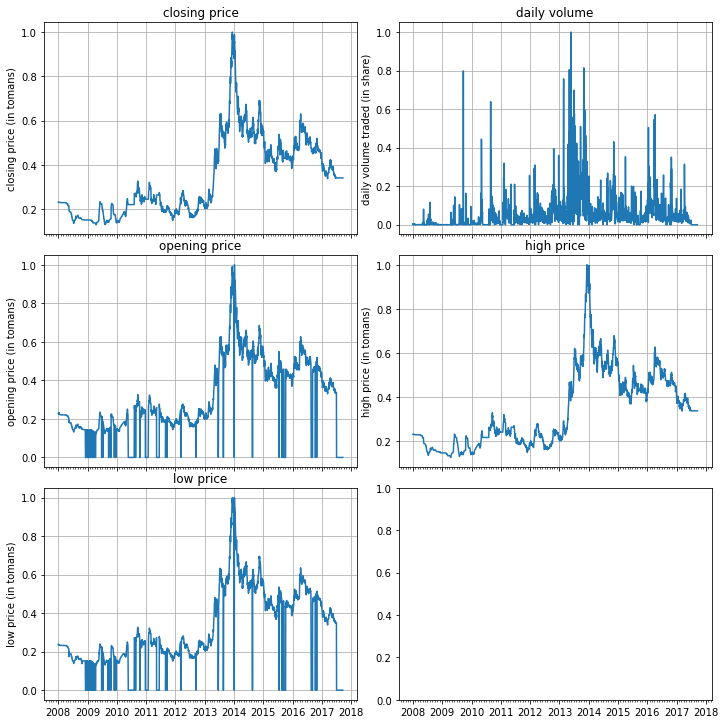

In [0]:
draw_ochlv(_training_period, training_start, training_end)

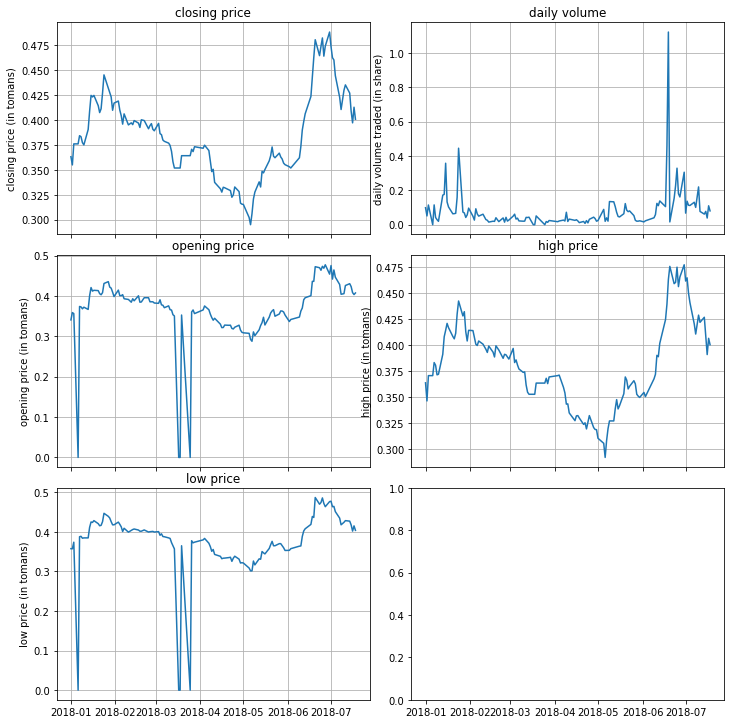

In [0]:
draw_ochlv(_testing_period, testing_start, testing_end)

So, the normalization is really suitable for this dataset.

**Now it is time to start training our model**

We use adam optimizer throughout this experiment and train the models for 5000 epochs.

In [0]:
epochs = 5000

In [0]:
optimizer = optimizers.Adam(learning_rate=0.001)

**Let's start with window size of 10.**

In [0]:
train_generator, test_generator = generate_datasets_for_model(data, labels, stock_with_max_trading_days, \
                                                              training_start, training_end, testing_start, \
                                                              testing_end)


layers = [
          # input_shape : batch_size, time_step, #features
          LSTM(300, batch_input_shape=(32,train_generator.dim[1], train_generator.dim[2]), stateful=True),
          Dense(84, activation='relu'),
          Dense(1),
          Activation('sigmoid')
         ]

metrics = [BinaryAccuracy(name='accuracy'), TruePositives(name='true_positives'), FalsePositives(name='false_positives'), TrueNegatives(name='true_negatives'), FalseNegatives(name='false_negatives')]
first_model = build_model(None, optimizer, layers, metrics=metrics)
first_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (32, 300)                 367200    
_________________________________________________________________
dense_10 (Dense)             (32, 84)                  25284     
_________________________________________________________________
dense_11 (Dense)             (32, 1)                   85        
_________________________________________________________________
activation_5 (Activation)    (32, 1)                   0         
Total params: 392,569
Trainable params: 392,569
Non-trainable params: 0
_________________________________________________________________


In [0]:
train_accs, train_losses = fit(first_model, epochs, train_generator)

epoch 1
----------->> Epoch 1/1   1.648 seconds , loss : 0.685    accuracy : 0.617    
epoch 2
----------->> Epoch 1/1   0.361 seconds , loss : 0.670    accuracy : 0.617    
epoch 3
----------->> Epoch 1/1   0.705 seconds , loss : 0.653    accuracy : 0.611    
epoch 4
----------->> Epoch 1/1   0.709 seconds , loss : 0.654    accuracy : 0.619    
epoch 5
----------->> Epoch 1/1   0.759 seconds , loss : 0.694    accuracy : 0.622    
epoch 6
----------->> Epoch 1/1   0.645 seconds , loss : 0.646    accuracy : 0.620    
epoch 7
----------->> Epoch 1/1   0.663 seconds , loss : 0.642    accuracy : 0.616    
epoch 8
----------->> Epoch 1/1   0.661 seconds , loss : 0.639    accuracy : 0.630    
epoch 9
----------->> Epoch 1/1   0.748 seconds , loss : 0.635    accuracy : 0.624    
epoch 10
----------->> Epoch 1/1   0.665 seconds , loss : 0.639    accuracy : 0.619    
epoch 11
----------->> Epoch 1/1   0.731 seconds , loss : 0.635    accuracy : 0.626    
epoch 12
----------->> Epoch 1/1   0.663 

----------->> Epoch 1/1   0.638 seconds , loss : 0.388    accuracy : 0.797    
epoch 187
----------->> Epoch 1/1   0.619 seconds , loss : 0.384    accuracy : 0.800    
epoch 188
----------->> Epoch 1/1   0.317 seconds , loss : 0.394    accuracy : 0.803    
epoch 189
----------->> Epoch 1/1   0.660 seconds , loss : 0.380    accuracy : 0.804    
epoch 190
----------->> Epoch 1/1   0.643 seconds , loss : 0.368    accuracy : 0.799    
epoch 191
----------->> Epoch 1/1   0.667 seconds , loss : 0.365    accuracy : 0.804    
epoch 192
----------->> Epoch 1/1   0.664 seconds , loss : 0.344    accuracy : 0.819    
epoch 193
----------->> Epoch 1/1   0.638 seconds , loss : 0.362    accuracy : 0.799    
epoch 194
----------->> Epoch 1/1   0.594 seconds , loss : 0.365    accuracy : 0.804    
epoch 195
----------->> Epoch 1/1   0.640 seconds , loss : 0.352    accuracy : 0.810    
epoch 196
----------->> Epoch 1/1   0.640 seconds , loss : 0.356    accuracy : 0.806    
epoch 197
----------->> Epoch 1

----------->> Epoch 1/1   0.668 seconds , loss : 0.098    accuracy : 0.961    
epoch 371
----------->> Epoch 1/1   0.691 seconds , loss : 0.100    accuracy : 0.961    
epoch 372
----------->> Epoch 1/1   0.681 seconds , loss : 0.123    accuracy : 0.949    
epoch 373
----------->> Epoch 1/1   0.649 seconds , loss : 0.108    accuracy : 0.958    
epoch 374
----------->> Epoch 1/1   0.761 seconds , loss : 0.097    accuracy : 0.966    
epoch 375
----------->> Epoch 1/1   0.685 seconds , loss : 0.112    accuracy : 0.952    
epoch 376
----------->> Epoch 1/1   0.688 seconds , loss : 0.104    accuracy : 0.956    
epoch 377
----------->> Epoch 1/1   0.661 seconds , loss : 0.119    accuracy : 0.951    
epoch 378
----------->> Epoch 1/1   0.666 seconds , loss : 0.106    accuracy : 0.957    
epoch 379
----------->> Epoch 1/1   0.670 seconds , loss : 0.146    accuracy : 0.942    
epoch 380
----------->> Epoch 1/1   0.664 seconds , loss : 0.145    accuracy : 0.944    
epoch 381
----------->> Epoch 1

----------->> Epoch 1/1   0.267 seconds , loss : 0.043    accuracy : 0.985    
epoch 555
----------->> Epoch 1/1   0.264 seconds , loss : 0.062    accuracy : 0.980    
epoch 556
----------->> Epoch 1/1   0.262 seconds , loss : 0.060    accuracy : 0.981    
epoch 557
----------->> Epoch 1/1   0.267 seconds , loss : 0.065    accuracy : 0.973    
epoch 558
----------->> Epoch 1/1   0.260 seconds , loss : 0.053    accuracy : 0.982    
epoch 559
----------->> Epoch 1/1   0.257 seconds , loss : 0.038    accuracy : 0.987    
epoch 560
----------->> Epoch 1/1   0.260 seconds , loss : 0.038    accuracy : 0.988    
epoch 561
----------->> Epoch 1/1   0.263 seconds , loss : 0.048    accuracy : 0.985    
epoch 562
----------->> Epoch 1/1   0.266 seconds , loss : 0.059    accuracy : 0.979    
epoch 563
----------->> Epoch 1/1   0.267 seconds , loss : 0.060    accuracy : 0.978    
epoch 564
----------->> Epoch 1/1   0.286 seconds , loss : 0.066    accuracy : 0.982    
epoch 565
----------->> Epoch 1

----------->> Epoch 1/1   0.269 seconds , loss : 0.041    accuracy : 0.985    
epoch 739
----------->> Epoch 1/1   0.267 seconds , loss : 0.030    accuracy : 0.989    
epoch 740
----------->> Epoch 1/1   0.267 seconds , loss : 0.028    accuracy : 0.991    
epoch 741
----------->> Epoch 1/1   0.266 seconds , loss : 0.033    accuracy : 0.989    
epoch 742
----------->> Epoch 1/1   0.267 seconds , loss : 0.040    accuracy : 0.988    
epoch 743
----------->> Epoch 1/1   0.265 seconds , loss : 0.044    accuracy : 0.986    
epoch 744
----------->> Epoch 1/1   0.267 seconds , loss : 0.057    accuracy : 0.983    
epoch 745
----------->> Epoch 1/1   0.264 seconds , loss : 0.053    accuracy : 0.981    
epoch 746
----------->> Epoch 1/1   0.268 seconds , loss : 0.065    accuracy : 0.977    
epoch 747
----------->> Epoch 1/1   0.273 seconds , loss : 0.037    accuracy : 0.990    
epoch 748
----------->> Epoch 1/1   0.263 seconds , loss : 0.033    accuracy : 0.990    
epoch 749
----------->> Epoch 1

----------->> Epoch 1/1   0.265 seconds , loss : 0.016    accuracy : 0.996    
epoch 923
----------->> Epoch 1/1   0.266 seconds , loss : 0.017    accuracy : 0.995    
epoch 924
----------->> Epoch 1/1   0.270 seconds , loss : 0.028    accuracy : 0.992    
epoch 925
----------->> Epoch 1/1   0.265 seconds , loss : 0.023    accuracy : 0.994    
epoch 926
----------->> Epoch 1/1   0.263 seconds , loss : 0.023    accuracy : 0.992    
epoch 927
----------->> Epoch 1/1   0.265 seconds , loss : 0.047    accuracy : 0.987    
epoch 928
----------->> Epoch 1/1   0.265 seconds , loss : 0.056    accuracy : 0.983    
epoch 929
----------->> Epoch 1/1   0.264 seconds , loss : 0.045    accuracy : 0.986    
epoch 930
----------->> Epoch 1/1   0.265 seconds , loss : 0.036    accuracy : 0.989    
epoch 931
----------->> Epoch 1/1   0.266 seconds , loss : 0.023    accuracy : 0.994    
epoch 932
----------->> Epoch 1/1   0.265 seconds , loss : 0.016    accuracy : 0.995    
epoch 933
----------->> Epoch 1

----------->> Epoch 1/1   0.266 seconds , loss : 0.026    accuracy : 0.991    
epoch 1015
----------->> Epoch 1/1   0.264 seconds , loss : 0.035    accuracy : 0.989    
epoch 1016
----------->> Epoch 1/1   0.267 seconds , loss : 0.021    accuracy : 0.994    
epoch 1017
----------->> Epoch 1/1   0.266 seconds , loss : 0.018    accuracy : 0.995    
epoch 1018
----------->> Epoch 1/1   0.266 seconds , loss : 0.019    accuracy : 0.995    
epoch 1019
----------->> Epoch 1/1   0.263 seconds , loss : 0.024    accuracy : 0.993    
epoch 1020
----------->> Epoch 1/1   0.262 seconds , loss : 0.026    accuracy : 0.992    
epoch 1021
----------->> Epoch 1/1   0.266 seconds , loss : 0.022    accuracy : 0.992    
epoch 1022
----------->> Epoch 1/1   0.263 seconds , loss : 0.021    accuracy : 0.994    
epoch 1023
----------->> Epoch 1/1   0.266 seconds , loss : 0.020    accuracy : 0.994    
epoch 1024
----------->> Epoch 1/1   0.266 seconds , loss : 0.016    accuracy : 0.996    
epoch 1025
----------

----------->> Epoch 1/1   0.263 seconds , loss : 0.018    accuracy : 0.994    
epoch 1197
----------->> Epoch 1/1   0.264 seconds , loss : 0.030    accuracy : 0.994    
epoch 1198
----------->> Epoch 1/1   0.263 seconds , loss : 0.018    accuracy : 0.995    
epoch 1199
----------->> Epoch 1/1   0.260 seconds , loss : 0.026    accuracy : 0.993    
epoch 1200
----------->> Epoch 1/1   0.265 seconds , loss : 0.015    accuracy : 0.997    
epoch 1201
----------->> Epoch 1/1   0.262 seconds , loss : 0.011    accuracy : 0.997    
epoch 1202
----------->> Epoch 1/1   0.273 seconds , loss : 0.013    accuracy : 0.997    
epoch 1203
----------->> Epoch 1/1   0.267 seconds , loss : 0.011    accuracy : 0.997    
epoch 1204
----------->> Epoch 1/1   0.264 seconds , loss : 0.012    accuracy : 0.997    
epoch 1205
----------->> Epoch 1/1   0.265 seconds , loss : 0.011    accuracy : 0.997    
epoch 1206
----------->> Epoch 1/1   0.261 seconds , loss : 0.012    accuracy : 0.997    
epoch 1207
----------

----------->> Epoch 1/1   0.266 seconds , loss : 0.010    accuracy : 0.998    
epoch 1379
----------->> Epoch 1/1   0.268 seconds , loss : 0.012    accuracy : 0.997    
epoch 1380
----------->> Epoch 1/1   0.303 seconds , loss : 0.014    accuracy : 0.997    
epoch 1381
----------->> Epoch 1/1   0.278 seconds , loss : 0.011    accuracy : 0.997    
epoch 1382
----------->> Epoch 1/1   0.290 seconds , loss : 0.014    accuracy : 0.996    
epoch 1383
----------->> Epoch 1/1   0.286 seconds , loss : 0.014    accuracy : 0.997    
epoch 1384
----------->> Epoch 1/1   0.288 seconds , loss : 0.012    accuracy : 0.996    
epoch 1385
----------->> Epoch 1/1   0.287 seconds , loss : 0.011    accuracy : 0.997    
epoch 1386
----------->> Epoch 1/1   0.312 seconds , loss : 0.010    accuracy : 0.997    
epoch 1387
----------->> Epoch 1/1   0.273 seconds , loss : 0.018    accuracy : 0.995    
epoch 1388
----------->> Epoch 1/1   0.277 seconds , loss : 0.016    accuracy : 0.996    
epoch 1389
----------

----------->> Epoch 1/1   0.321 seconds , loss : 0.017    accuracy : 0.997    
epoch 1561
----------->> Epoch 1/1   0.279 seconds , loss : 0.013    accuracy : 0.997    
epoch 1562
----------->> Epoch 1/1   0.317 seconds , loss : 0.012    accuracy : 0.998    
epoch 1563
----------->> Epoch 1/1   0.305 seconds , loss : 0.011    accuracy : 0.998    
epoch 1564
----------->> Epoch 1/1   0.310 seconds , loss : 0.008    accuracy : 0.998    
epoch 1565
----------->> Epoch 1/1   0.297 seconds , loss : 0.009    accuracy : 0.998    
epoch 1566
----------->> Epoch 1/1   0.317 seconds , loss : 0.009    accuracy : 0.997    
epoch 1567
----------->> Epoch 1/1   0.275 seconds , loss : 0.009    accuracy : 0.998    
epoch 1568
----------->> Epoch 1/1   0.268 seconds , loss : 0.012    accuracy : 0.997    
epoch 1569
----------->> Epoch 1/1   0.268 seconds , loss : 0.023    accuracy : 0.994    
epoch 1570
----------->> Epoch 1/1   0.266 seconds , loss : 0.028    accuracy : 0.989    
epoch 1571
----------

----------->> Epoch 1/1   0.267 seconds , loss : 0.009    accuracy : 0.998    
epoch 1743
----------->> Epoch 1/1   0.266 seconds , loss : 0.008    accuracy : 0.998    
epoch 1744
----------->> Epoch 1/1   0.268 seconds , loss : 0.012    accuracy : 0.995    
epoch 1745
----------->> Epoch 1/1   0.258 seconds , loss : 0.014    accuracy : 0.997    
epoch 1746
----------->> Epoch 1/1   0.266 seconds , loss : 0.010    accuracy : 0.997    
epoch 1747
----------->> Epoch 1/1   0.263 seconds , loss : 0.009    accuracy : 0.997    
epoch 1748
----------->> Epoch 1/1   0.262 seconds , loss : 0.009    accuracy : 0.997    
epoch 1749
----------->> Epoch 1/1   0.264 seconds , loss : 0.012    accuracy : 0.996    
epoch 1750
----------->> Epoch 1/1   0.262 seconds , loss : 0.015    accuracy : 0.997    
epoch 1751
----------->> Epoch 1/1   0.261 seconds , loss : 0.007    accuracy : 0.998    
epoch 1752
----------->> Epoch 1/1   0.267 seconds , loss : 0.009    accuracy : 0.997    
epoch 1753
----------

----------->> Epoch 1/1   0.269 seconds , loss : 0.011    accuracy : 0.997    
epoch 1925
----------->> Epoch 1/1   0.268 seconds , loss : 0.013    accuracy : 0.997    
epoch 1926
----------->> Epoch 1/1   0.264 seconds , loss : 0.038    accuracy : 0.989    
epoch 1927
----------->> Epoch 1/1   0.260 seconds , loss : 0.022    accuracy : 0.994    
epoch 1928
----------->> Epoch 1/1   0.266 seconds , loss : 0.013    accuracy : 0.996    
epoch 1929
----------->> Epoch 1/1   0.265 seconds , loss : 0.011    accuracy : 0.997    
epoch 1930
----------->> Epoch 1/1   0.263 seconds , loss : 0.011    accuracy : 0.997    
epoch 1931
----------->> Epoch 1/1   0.264 seconds , loss : 0.008    accuracy : 0.998    
epoch 1932
----------->> Epoch 1/1   0.263 seconds , loss : 0.008    accuracy : 0.998    
epoch 1933
----------->> Epoch 1/1   0.264 seconds , loss : 0.010    accuracy : 0.997    
epoch 1934
----------->> Epoch 1/1   0.266 seconds , loss : 0.009    accuracy : 0.998    
epoch 1935
----------

----------->> Epoch 1/1   0.267 seconds , loss : 0.006    accuracy : 0.999    
epoch 2107
----------->> Epoch 1/1   0.271 seconds , loss : 0.006    accuracy : 0.998    
epoch 2108
----------->> Epoch 1/1   0.268 seconds , loss : 0.006    accuracy : 0.998    
epoch 2109
----------->> Epoch 1/1   0.274 seconds , loss : 0.008    accuracy : 0.997    
epoch 2110
----------->> Epoch 1/1   0.260 seconds , loss : 0.006    accuracy : 0.997    
epoch 2111
----------->> Epoch 1/1   0.274 seconds , loss : 0.007    accuracy : 0.997    
epoch 2112
----------->> Epoch 1/1   0.272 seconds , loss : 0.013    accuracy : 0.996    
epoch 2113
----------->> Epoch 1/1   0.279 seconds , loss : 0.010    accuracy : 0.998    
epoch 2114
----------->> Epoch 1/1   0.296 seconds , loss : 0.005    accuracy : 0.997    
epoch 2115
----------->> Epoch 1/1   0.310 seconds , loss : 0.008    accuracy : 0.997    
epoch 2116
----------->> Epoch 1/1   0.310 seconds , loss : 0.013    accuracy : 0.995    
epoch 2117
----------

----------->> Epoch 1/1   0.274 seconds , loss : 0.012    accuracy : 0.997    
epoch 2289
----------->> Epoch 1/1   0.294 seconds , loss : 0.007    accuracy : 0.998    
epoch 2290
----------->> Epoch 1/1   0.305 seconds , loss : 0.006    accuracy : 0.998    
epoch 2291
----------->> Epoch 1/1   0.285 seconds , loss : 0.011    accuracy : 0.996    
epoch 2292
----------->> Epoch 1/1   0.277 seconds , loss : 0.012    accuracy : 0.997    
epoch 2293
----------->> Epoch 1/1   0.336 seconds , loss : 0.009    accuracy : 0.996    
epoch 2294
----------->> Epoch 1/1   0.269 seconds , loss : 0.006    accuracy : 0.999    
epoch 2295
----------->> Epoch 1/1   0.274 seconds , loss : 0.004    accuracy : 0.999    
epoch 2296
----------->> Epoch 1/1   0.278 seconds , loss : 0.004    accuracy : 0.999    
epoch 2297
----------->> Epoch 1/1   0.319 seconds , loss : 0.006    accuracy : 0.998    
epoch 2298
----------->> Epoch 1/1   0.315 seconds , loss : 0.005    accuracy : 0.999    
epoch 2299
----------

----------->> Epoch 1/1   0.263 seconds , loss : 0.007    accuracy : 0.998    
epoch 2471
----------->> Epoch 1/1   0.269 seconds , loss : 0.007    accuracy : 0.998    
epoch 2472
----------->> Epoch 1/1   0.266 seconds , loss : 0.015    accuracy : 0.994    
epoch 2473
----------->> Epoch 1/1   0.266 seconds , loss : 0.008    accuracy : 0.998    
epoch 2474
----------->> Epoch 1/1   0.271 seconds , loss : 0.010    accuracy : 0.998    
epoch 2475
----------->> Epoch 1/1   0.264 seconds , loss : 0.007    accuracy : 0.998    
epoch 2476
----------->> Epoch 1/1   0.264 seconds , loss : 0.007    accuracy : 0.998    
epoch 2477
----------->> Epoch 1/1   0.271 seconds , loss : 0.006    accuracy : 0.998    
epoch 2478
----------->> Epoch 1/1   0.267 seconds , loss : 0.014    accuracy : 0.997    
epoch 2479
----------->> Epoch 1/1   0.261 seconds , loss : 0.005    accuracy : 0.999    
epoch 2480
----------->> Epoch 1/1   0.267 seconds , loss : 0.004    accuracy : 0.999    
epoch 2481
----------

----------->> Epoch 1/1   0.264 seconds , loss : 0.011    accuracy : 0.997    
epoch 2653
----------->> Epoch 1/1   0.269 seconds , loss : 0.007    accuracy : 0.997    
epoch 2654
----------->> Epoch 1/1   0.264 seconds , loss : 0.005    accuracy : 0.998    
epoch 2655
----------->> Epoch 1/1   0.270 seconds , loss : 0.006    accuracy : 0.998    
epoch 2656
----------->> Epoch 1/1   0.271 seconds , loss : 0.003    accuracy : 0.999    
epoch 2657
----------->> Epoch 1/1   0.258 seconds , loss : 0.006    accuracy : 0.997    
epoch 2658
----------->> Epoch 1/1   0.265 seconds , loss : 0.006    accuracy : 0.999    
epoch 2659
----------->> Epoch 1/1   0.259 seconds , loss : 0.005    accuracy : 0.999    
epoch 2660
----------->> Epoch 1/1   0.264 seconds , loss : 0.007    accuracy : 0.999    
epoch 2661
----------->> Epoch 1/1   0.264 seconds , loss : 0.006    accuracy : 0.997    
epoch 2662
----------->> Epoch 1/1   0.263 seconds , loss : 0.008    accuracy : 0.998    
epoch 2663
----------

----------->> Epoch 1/1   0.286 seconds , loss : 0.007    accuracy : 0.998    
epoch 2835
----------->> Epoch 1/1   0.291 seconds , loss : 0.008    accuracy : 0.998    
epoch 2836
----------->> Epoch 1/1   0.268 seconds , loss : 0.007    accuracy : 0.998    
epoch 2837
----------->> Epoch 1/1   0.269 seconds , loss : 0.005    accuracy : 0.999    
epoch 2838
----------->> Epoch 1/1   0.263 seconds , loss : 0.004    accuracy : 0.999    
epoch 2839
----------->> Epoch 1/1   0.266 seconds , loss : 0.010    accuracy : 0.997    
epoch 2840
----------->> Epoch 1/1   0.266 seconds , loss : 0.011    accuracy : 0.997    
epoch 2841
----------->> Epoch 1/1   0.268 seconds , loss : 0.015    accuracy : 0.995    
epoch 2842
----------->> Epoch 1/1   0.264 seconds , loss : 0.005    accuracy : 0.998    
epoch 2843
----------->> Epoch 1/1   0.265 seconds , loss : 0.004    accuracy : 0.999    
epoch 2844
----------->> Epoch 1/1   0.266 seconds , loss : 0.011    accuracy : 0.997    
epoch 2845
----------

----------->> Epoch 1/1   0.269 seconds , loss : 0.005    accuracy : 0.999    
epoch 3017
----------->> Epoch 1/1   0.270 seconds , loss : 0.006    accuracy : 0.998    
epoch 3018
----------->> Epoch 1/1   0.265 seconds , loss : 0.004    accuracy : 0.997    
epoch 3019
----------->> Epoch 1/1   0.265 seconds , loss : 0.006    accuracy : 0.999    
epoch 3020
----------->> Epoch 1/1   0.265 seconds , loss : 0.004    accuracy : 0.999    
epoch 3021
----------->> Epoch 1/1   0.264 seconds , loss : 0.004    accuracy : 0.999    
epoch 3022
----------->> Epoch 1/1   0.263 seconds , loss : 0.004    accuracy : 0.998    
epoch 3023
----------->> Epoch 1/1   0.265 seconds , loss : 0.004    accuracy : 0.998    
epoch 3024
----------->> Epoch 1/1   0.268 seconds , loss : 0.007    accuracy : 0.997    
epoch 3025
----------->> Epoch 1/1   0.265 seconds , loss : 0.033    accuracy : 0.993    
epoch 3026
----------->> Epoch 1/1   0.266 seconds , loss : 0.010    accuracy : 0.998    
epoch 3027
----------

----------->> Epoch 1/1   0.268 seconds , loss : 0.006    accuracy : 0.998    
epoch 3199
----------->> Epoch 1/1   0.261 seconds , loss : 0.009    accuracy : 0.998    
epoch 3200
----------->> Epoch 1/1   0.264 seconds , loss : 0.007    accuracy : 0.997    
epoch 3201
----------->> Epoch 1/1   0.266 seconds , loss : 0.004    accuracy : 0.998    
epoch 3202
----------->> Epoch 1/1   0.266 seconds , loss : 0.007    accuracy : 0.998    
epoch 3203
----------->> Epoch 1/1   0.264 seconds , loss : 0.004    accuracy : 0.998    
epoch 3204
----------->> Epoch 1/1   0.267 seconds , loss : 0.004    accuracy : 0.998    
epoch 3205
----------->> Epoch 1/1   0.264 seconds , loss : 0.003    accuracy : 1.000    
epoch 3206
----------->> Epoch 1/1   0.265 seconds , loss : 0.002    accuracy : 1.000    
epoch 3207
----------->> Epoch 1/1   0.264 seconds , loss : 0.005    accuracy : 0.999    
epoch 3208
----------->> Epoch 1/1   0.265 seconds , loss : 0.006    accuracy : 0.998    
epoch 3209
----------

----------->> Epoch 1/1   0.268 seconds , loss : 0.004    accuracy : 0.999    
epoch 3381
----------->> Epoch 1/1   0.269 seconds , loss : 0.008    accuracy : 0.997    
epoch 3382
----------->> Epoch 1/1   0.259 seconds , loss : 0.009    accuracy : 0.996    
epoch 3383
----------->> Epoch 1/1   0.263 seconds , loss : 0.005    accuracy : 0.997    
epoch 3384
----------->> Epoch 1/1   0.264 seconds , loss : 0.003    accuracy : 0.999    
epoch 3385
----------->> Epoch 1/1   0.267 seconds , loss : 0.002    accuracy : 0.999    
epoch 3386
----------->> Epoch 1/1   0.262 seconds , loss : 0.005    accuracy : 0.999    
epoch 3387
----------->> Epoch 1/1   0.264 seconds , loss : 0.005    accuracy : 0.998    
epoch 3388
----------->> Epoch 1/1   0.267 seconds , loss : 0.006    accuracy : 0.998    
epoch 3389
----------->> Epoch 1/1   0.264 seconds , loss : 0.003    accuracy : 0.999    
epoch 3390
----------->> Epoch 1/1   0.267 seconds , loss : 0.003    accuracy : 0.999    
epoch 3391
----------

----------->> Epoch 1/1   0.264 seconds , loss : 0.004    accuracy : 0.999    
epoch 3563
----------->> Epoch 1/1   0.274 seconds , loss : 0.002    accuracy : 1.000    
epoch 3564
----------->> Epoch 1/1   0.263 seconds , loss : 0.014    accuracy : 0.996    
epoch 3565
----------->> Epoch 1/1   0.262 seconds , loss : 0.009    accuracy : 0.998    
epoch 3566
----------->> Epoch 1/1   0.266 seconds , loss : 0.005    accuracy : 0.999    
epoch 3567
----------->> Epoch 1/1   0.269 seconds , loss : 0.005    accuracy : 0.998    
epoch 3568
----------->> Epoch 1/1   0.264 seconds , loss : 0.006    accuracy : 0.999    
epoch 3569
----------->> Epoch 1/1   0.271 seconds , loss : 0.005    accuracy : 0.998    
epoch 3570
----------->> Epoch 1/1   0.265 seconds , loss : 0.005    accuracy : 0.998    
epoch 3571
----------->> Epoch 1/1   0.264 seconds , loss : 0.006    accuracy : 0.998    
epoch 3572
----------->> Epoch 1/1   0.264 seconds , loss : 0.003    accuracy : 0.999    
epoch 3573
----------

----------->> Epoch 1/1   0.272 seconds , loss : 0.006    accuracy : 0.997    
epoch 3745
----------->> Epoch 1/1   0.271 seconds , loss : 0.002    accuracy : 0.999    
epoch 3746
----------->> Epoch 1/1   0.261 seconds , loss : 0.003    accuracy : 0.999    
epoch 3747
----------->> Epoch 1/1   0.266 seconds , loss : 0.042    accuracy : 0.991    
epoch 3748
----------->> Epoch 1/1   0.268 seconds , loss : 0.023    accuracy : 0.995    
epoch 3749
----------->> Epoch 1/1   0.264 seconds , loss : 0.009    accuracy : 0.997    
epoch 3750
----------->> Epoch 1/1   0.264 seconds , loss : 0.005    accuracy : 0.998    
epoch 3751
----------->> Epoch 1/1   0.262 seconds , loss : 0.004    accuracy : 0.999    
epoch 3752
----------->> Epoch 1/1   0.267 seconds , loss : 0.002    accuracy : 1.000    
epoch 3753
----------->> Epoch 1/1   0.266 seconds , loss : 0.004    accuracy : 0.999    
epoch 3754
----------->> Epoch 1/1   0.265 seconds , loss : 0.004    accuracy : 0.998    
epoch 3755
----------

----------->> Epoch 1/1   0.268 seconds , loss : 0.002    accuracy : 0.999    
epoch 3927
----------->> Epoch 1/1   0.267 seconds , loss : 0.002    accuracy : 1.000    
epoch 3928
----------->> Epoch 1/1   0.316 seconds , loss : 0.002    accuracy : 0.999    
epoch 3929
----------->> Epoch 1/1   0.276 seconds , loss : 0.002    accuracy : 0.999    
epoch 3930
----------->> Epoch 1/1   0.320 seconds , loss : 0.004    accuracy : 0.999    
epoch 3931
----------->> Epoch 1/1   0.284 seconds , loss : 0.002    accuracy : 0.999    
epoch 3932
----------->> Epoch 1/1   0.295 seconds , loss : 0.004    accuracy : 0.999    
epoch 3933
----------->> Epoch 1/1   0.265 seconds , loss : 0.004    accuracy : 0.999    
epoch 3934
----------->> Epoch 1/1   0.286 seconds , loss : 0.002    accuracy : 1.000    
epoch 3935
----------->> Epoch 1/1   0.291 seconds , loss : 0.002    accuracy : 0.999    
epoch 3936
----------->> Epoch 1/1   0.289 seconds , loss : 0.004    accuracy : 0.999    
epoch 3937
----------

----------->> Epoch 1/1   0.268 seconds , loss : 0.003    accuracy : 0.999    
epoch 4109
----------->> Epoch 1/1   0.267 seconds , loss : 0.003    accuracy : 0.999    
epoch 4110
----------->> Epoch 1/1   0.267 seconds , loss : 0.002    accuracy : 0.999    
epoch 4111
----------->> Epoch 1/1   0.266 seconds , loss : 0.003    accuracy : 1.000    
epoch 4112
----------->> Epoch 1/1   0.267 seconds , loss : 0.003    accuracy : 0.999    
epoch 4113
----------->> Epoch 1/1   0.268 seconds , loss : 0.004    accuracy : 0.999    
epoch 4114
----------->> Epoch 1/1   0.262 seconds , loss : 0.001    accuracy : 0.999    
epoch 4115
----------->> Epoch 1/1   0.267 seconds , loss : 0.007    accuracy : 0.998    
epoch 4116
----------->> Epoch 1/1   0.267 seconds , loss : 0.007    accuracy : 0.997    
epoch 4117
----------->> Epoch 1/1   0.269 seconds , loss : 0.003    accuracy : 1.000    
epoch 4118
----------->> Epoch 1/1   0.265 seconds , loss : 0.003    accuracy : 0.999    
epoch 4119
----------

----------->> Epoch 1/1   0.279 seconds , loss : 0.017    accuracy : 0.993    
epoch 4291
----------->> Epoch 1/1   0.266 seconds , loss : 0.008    accuracy : 0.998    
epoch 4292
----------->> Epoch 1/1   0.308 seconds , loss : 0.004    accuracy : 0.999    
epoch 4293
----------->> Epoch 1/1   0.283 seconds , loss : 0.004    accuracy : 0.998    
epoch 4294
----------->> Epoch 1/1   0.303 seconds , loss : 0.015    accuracy : 0.999    
epoch 4295
----------->> Epoch 1/1   0.303 seconds , loss : 0.004    accuracy : 0.999    
epoch 4296
----------->> Epoch 1/1   0.302 seconds , loss : 0.003    accuracy : 0.999    
epoch 4297
----------->> Epoch 1/1   0.302 seconds , loss : 0.003    accuracy : 0.998    
epoch 4298
----------->> Epoch 1/1   0.308 seconds , loss : 0.019    accuracy : 0.994    
epoch 4299
----------->> Epoch 1/1   0.278 seconds , loss : 0.009    accuracy : 0.997    
epoch 4300
----------->> Epoch 1/1   0.298 seconds , loss : 0.009    accuracy : 0.997    
epoch 4301
----------

----------->> Epoch 1/1   0.297 seconds , loss : 0.004    accuracy : 0.999    
epoch 4473
----------->> Epoch 1/1   0.292 seconds , loss : 0.003    accuracy : 0.999    
epoch 4474
----------->> Epoch 1/1   0.291 seconds , loss : 0.005    accuracy : 0.999    
epoch 4475
----------->> Epoch 1/1   0.289 seconds , loss : 0.002    accuracy : 0.999    
epoch 4476
----------->> Epoch 1/1   0.273 seconds , loss : 0.005    accuracy : 0.998    
epoch 4477
----------->> Epoch 1/1   0.274 seconds , loss : 0.008    accuracy : 0.998    
epoch 4478
----------->> Epoch 1/1   0.267 seconds , loss : 0.001    accuracy : 0.999    
epoch 4479
----------->> Epoch 1/1   0.258 seconds , loss : 0.007    accuracy : 0.998    
epoch 4480
----------->> Epoch 1/1   0.266 seconds , loss : 0.003    accuracy : 0.999    
epoch 4481
----------->> Epoch 1/1   0.266 seconds , loss : 0.002    accuracy : 1.000    
epoch 4482
----------->> Epoch 1/1   0.266 seconds , loss : 0.004    accuracy : 0.999    
epoch 4483
----------

----------->> Epoch 1/1   0.263 seconds , loss : 0.005    accuracy : 0.998    
epoch 4655
----------->> Epoch 1/1   0.268 seconds , loss : 0.005    accuracy : 0.999    
epoch 4656
----------->> Epoch 1/1   0.267 seconds , loss : 0.003    accuracy : 0.998    
epoch 4657
----------->> Epoch 1/1   0.280 seconds , loss : 0.003    accuracy : 0.999    
epoch 4658
----------->> Epoch 1/1   0.310 seconds , loss : 0.004    accuracy : 0.999    
epoch 4659
----------->> Epoch 1/1   0.268 seconds , loss : 0.004    accuracy : 0.998    
epoch 4660
----------->> Epoch 1/1   0.266 seconds , loss : 0.004    accuracy : 0.998    
epoch 4661
----------->> Epoch 1/1   0.270 seconds , loss : 0.002    accuracy : 0.999    
epoch 4662
----------->> Epoch 1/1   0.328 seconds , loss : 0.003    accuracy : 0.999    
epoch 4663
----------->> Epoch 1/1   0.268 seconds , loss : 0.003    accuracy : 0.999    
epoch 4664
----------->> Epoch 1/1   0.266 seconds , loss : 0.003    accuracy : 0.999    
epoch 4665
----------

----------->> Epoch 1/1   0.313 seconds , loss : 0.005    accuracy : 0.998    
epoch 4837
----------->> Epoch 1/1   0.288 seconds , loss : 0.002    accuracy : 1.000    
epoch 4838
----------->> Epoch 1/1   0.320 seconds , loss : 0.006    accuracy : 0.998    
epoch 4839
----------->> Epoch 1/1   0.308 seconds , loss : 0.010    accuracy : 0.997    
epoch 4840
----------->> Epoch 1/1   0.309 seconds , loss : 0.010    accuracy : 0.998    
epoch 4841
----------->> Epoch 1/1   0.301 seconds , loss : 0.004    accuracy : 0.998    
epoch 4842
----------->> Epoch 1/1   0.318 seconds , loss : 0.003    accuracy : 0.999    
epoch 4843
----------->> Epoch 1/1   0.292 seconds , loss : 0.003    accuracy : 0.999    
epoch 4844
----------->> Epoch 1/1   0.289 seconds , loss : 0.001    accuracy : 1.000    
epoch 4845
----------->> Epoch 1/1   0.291 seconds , loss : 0.003    accuracy : 0.999    
epoch 4846
----------->> Epoch 1/1   0.292 seconds , loss : 0.002    accuracy : 0.999    
epoch 4847
----------

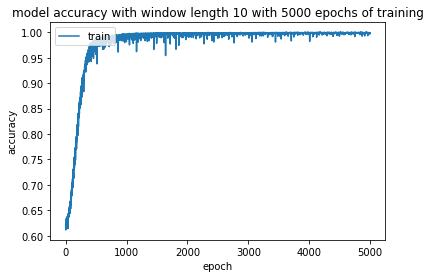

In [0]:
plt.plot(train_accs)
plt.title('model accuracy with window length 10 with 5000 epochs of training')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

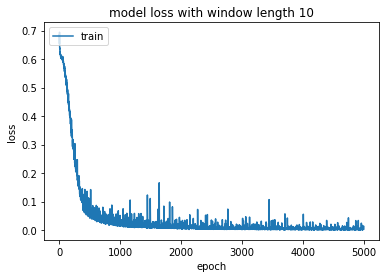

In [0]:
plt.plot(train_losses)
plt.title('model loss with window length 10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [0]:
first_model.reset_states()
test_results = calc_pos_neg_rate(first_model.evaluate(x=test_generator, verbose=0))

In [0]:
first_model.reset_states()
train_results = calc_pos_neg_rate(first_model.evaluate(x=train_generator, verbose=0))

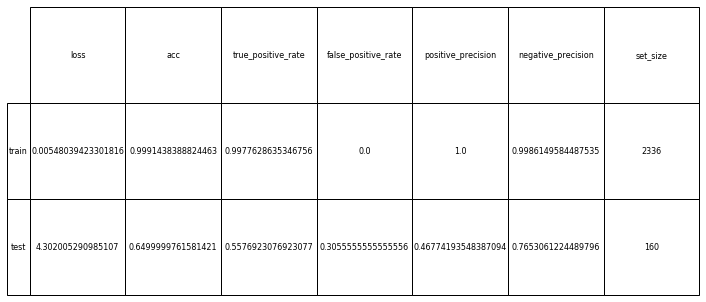

In [0]:
tabular_test_train_results(train_generator, test_generator, train_results, test_results)

Let's save the achieved model for further use.

In [0]:
first_model.save('model_stateful_10.h5')

**Let's try a bigger network with more LSTM layers to see how it works**

In [0]:
epochs = 5000

In [0]:
optimizer = optimizers.Adam(learning_rate=0.0001)

In [50]:
train_generator, test_generator = generate_datasets_for_model(data, labels, stock_with_max_trading_days, \
                                                              training_start, training_end, testing_start, \
                                                              testing_end)

layers = [
          # input_shape : batch_size, time_step, #features
          LSTM(300, batch_input_shape=(32,train_generator.dim[1], train_generator.dim[2]),
               return_sequences=True, stateful=True),
          LSTM(1200,
               stateful=True),
          Dense(250, activation='relu'),
          Dense(80, activation='relu'),
          Dense(1),
          Activation('sigmoid')
         ]

metrics = [BinaryAccuracy(name='accuracy'), TruePositives(name='true_positives'), FalsePositives(name='false_positives'), TrueNegatives(name='true_negatives'), FalseNegatives(name='false_negatives')]
big_model = build_model(None, optimizer, layers, metrics=metrics)
big_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (32, 10, 300)             367200    
_________________________________________________________________
lstm_17 (LSTM)               (32, 1200)                7204800   
_________________________________________________________________
dense_15 (Dense)             (32, 250)                 300250    
_________________________________________________________________
dense_16 (Dense)             (32, 80)                  20080     
_________________________________________________________________
dense_17 (Dense)             (32, 1)                   81        
_________________________________________________________________
activation_5 (Activation)    (32, 1)                   0         
Total params: 7,892,411
Trainable params: 7,892,411
Non-trainable params: 0
____________________________________________

In [51]:
train_accs, train_losses = fit(big_model, epochs, train_generator)

Streaming output truncated to the last 5000 lines.
----------->> Epoch 1/1   0.682 seconds , loss : 0.015    accuracy : 0.996    
epoch 2502
----------->> Epoch 1/1   0.683 seconds , loss : 0.011    accuracy : 0.997    
epoch 2503
----------->> Epoch 1/1   0.679 seconds , loss : 0.006    accuracy : 0.998    
epoch 2504
----------->> Epoch 1/1   0.682 seconds , loss : 0.007    accuracy : 0.998    
epoch 2505
----------->> Epoch 1/1   0.681 seconds , loss : 0.006    accuracy : 0.999    
epoch 2506
----------->> Epoch 1/1   0.683 seconds , loss : 0.008    accuracy : 0.998    
epoch 2507
----------->> Epoch 1/1   0.682 seconds , loss : 0.008    accuracy : 0.998    
epoch 2508
----------->> Epoch 1/1   0.684 seconds , loss : 0.005    accuracy : 0.998    
epoch 2509
----------->> Epoch 1/1   0.667 seconds , loss : 0.006    accuracy : 0.998    
epoch 2510
----------->> Epoch 1/1   0.667 seconds , loss : 0.007    accuracy : 0.997    
epoch 2511
----------->> Epoch 1/1   0.669 seconds , loss : 

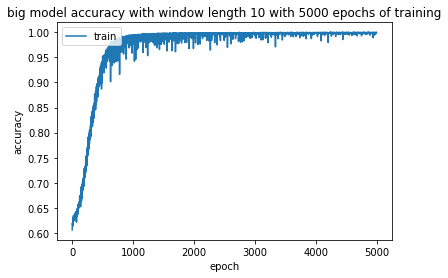

In [52]:
plt.plot(train_accs)
plt.title('big model accuracy with window length 10 with 5000 epochs of training')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

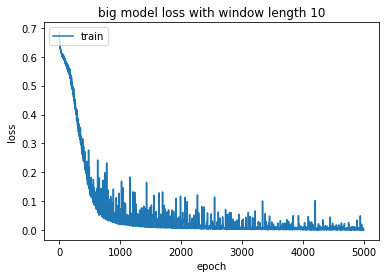

In [53]:
plt.plot(train_losses)
plt.title('big model loss with window length 10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [0]:
big_model.reset_states()
test_results = calc_pos_neg_rate(big_model.evaluate(x=test_generator, verbose=0))

In [0]:
big_model.reset_states()
train_results = calc_pos_neg_rate(big_model.evaluate(x=train_generator, verbose=0))

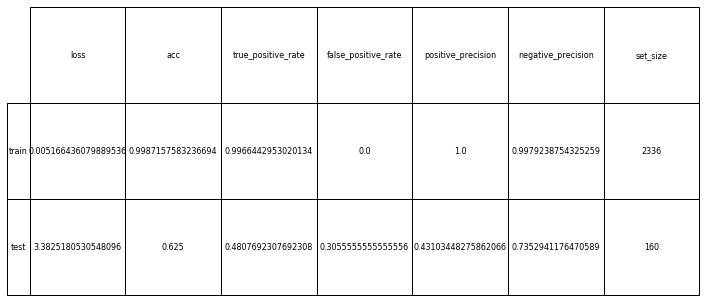

In [57]:
tabular_test_train_results(train_generator, test_generator, train_results, test_results)

In [0]:
big_model.save('big_model_10.h5')

In [0]:
!cp 'big_model_10.h5' $PROJECT

In [61]:
!ls $PROJECT

 big_model_10.h5    'Publications Notes'
 data.zip	    'Stock Notes'
 Features	     Stock_Publications.gdoc
 Implementation      Undergrad_Final_Project_ProgressLine.gdoc
 Operational.ipynb


## **Transfer Learning**

**In this section, we load the pre-trained model and then do partial tuning with training it on the stock with second max trading days. Then, we test it to get accuracy of the model. We set the window length to 10.**

In [0]:
stock_with_second_max_trading_days = ten_stocks_with_max_trading_days['TICKER'].iloc[1]
data_related_to_second = data[data['TICKER'] == stock_with_second_max_trading_days]

First of all, let's visualize the whole dataset related to second max stock.

In [0]:
train_start = pandas.to_datetime('20080101', format='%Y%m%d', errors='ignore')
train_end = pandas.to_datetime('20160719', format='%Y%m%d', errors='ignore')
test_start = pandas.to_datetime('20170101', format='%Y%m%d', errors='ignore')
test_end = pandas.to_datetime('20180101', format='%Y%m%d', errors='ignore')

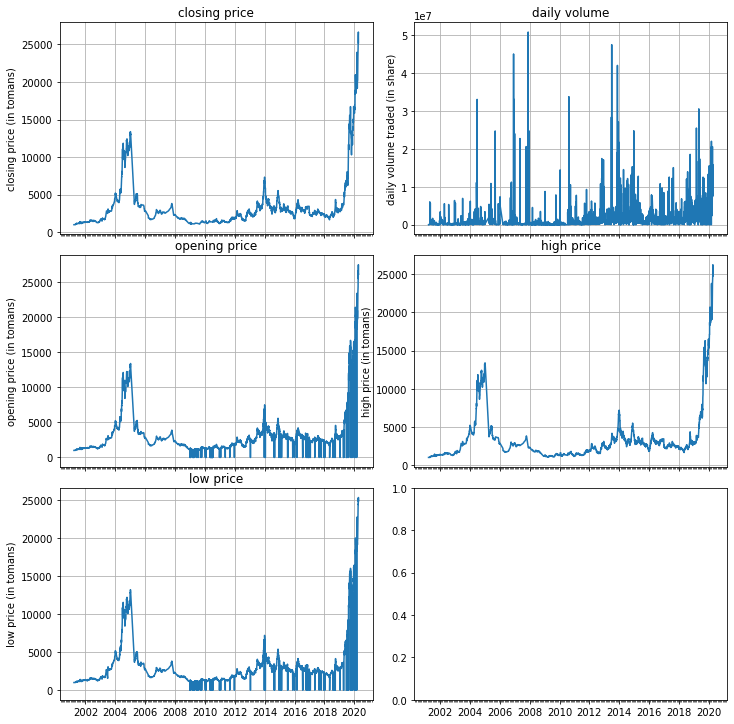

In [0]:
start_period = pandas.to_datetime('20010101', format='%Y%m%d', errors='ignore')
end_period = pandas.to_datetime('20200414', format='%Y%m%d', errors='ignore')
draw_ochlv(data_related_to_second, start_period, end_period)

We first split the dataset into train and test sets.

Now, let's do some visualization. We draw the changes of features for both datasets.

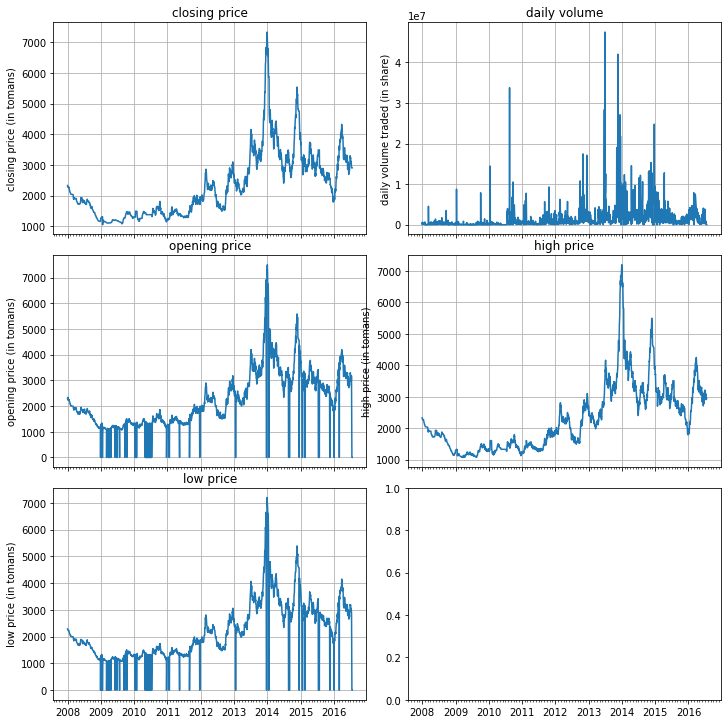

In [0]:
draw_ochlv(data_related_to_second, train_start, train_end)

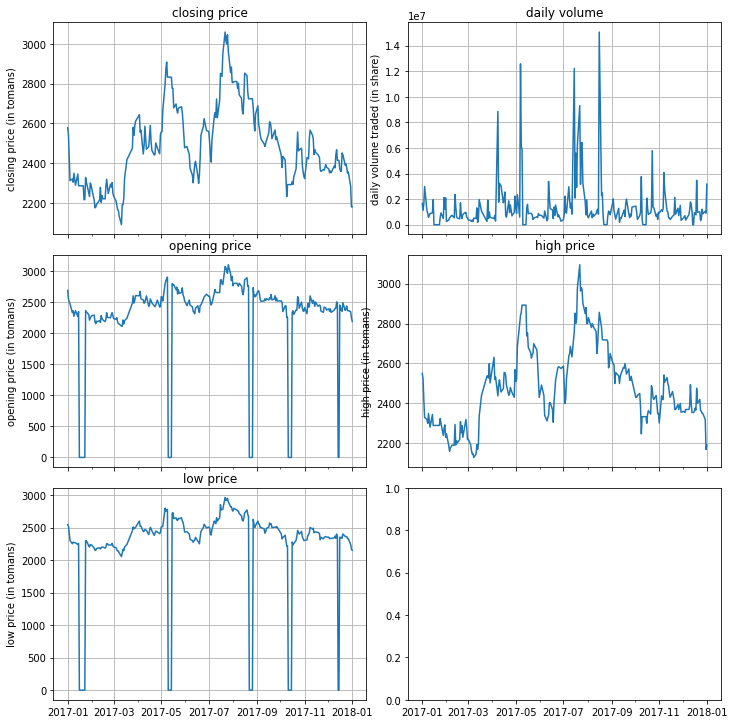

In [0]:
draw_ochlv(data_related_to_second, test_start, test_end)

Next, we load the pretrained model

In [0]:
train_generator, test_generator = generate_datasets_for_model(data, labels, stock_with_second_max_trading_days, train_start, train_end, test_start, test_end)

In [0]:
optimizer = optimizers.Adam(learning_rate=0.001)

**Now, we build the model. This time we set LSTM layer to be non-trainable. We expect that LSTM layer has learned the patterns in the oscillation of prices in stock.**

In [0]:
from tensorflow.keras.models import load_model


layers = [
          # input_shape : batch_size, time_step, #features
          LSTM(300, batch_input_shape=(32,train_generator.dim[1], train_generator.dim[2]), stateful=True,
                trainable=False),
          Dense(84, activation='relu'),
          Dense(1),
          Activation('sigmoid')
         ]

metrics = [BinaryAccuracy(name='accuracy'), TruePositives(name='true_positives'), FalsePositives(name='false_positives'), TrueNegatives(name='true_negatives'), FalseNegatives(name='false_negatives')]
base_model = build_model(train_generator.dim, optimizer, layers=layers, metrics=metrics)
base_model.load_weights(join(COLAB_DIR,'model_stateful_10.h5'))
base_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (32, 300)                 367200    
_________________________________________________________________
dense_18 (Dense)             (32, 84)                  25284     
_________________________________________________________________
dense_19 (Dense)             (32, 1)                   85        
_________________________________________________________________
activation_9 (Activation)    (32, 1)                   0         
Total params: 392,569
Trainable params: 25,369
Non-trainable params: 367,200
_________________________________________________________________


**Let's test the model on this stock to see the results without training.**

In [0]:
base_model.reset_states()
test_results = calc_pos_neg_rate(base_model.evaluate(x=test_generator, verbose=0))

In [0]:
base_model.reset_states()
train_results = calc_pos_neg_rate(base_model.evaluate(x=train_generator, verbose=0))

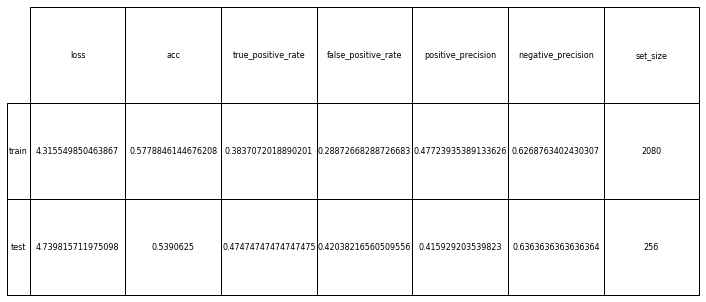

In [0]:
tabular_test_train_results(train_generator, test_generator, train_results, test_results)

Now, let's train the model for 600 epochs.

In [0]:
epochs = 600

In [0]:
train_accs, train_losses = fit(base_model, epochs, train_generator)

epoch 1
----------->> Epoch 1/1   1.543 seconds , loss : 3.583    accuracy : 0.551    
epoch 2
----------->> Epoch 1/1   0.211 seconds , loss : 2.474    accuracy : 0.571    
epoch 3
----------->> Epoch 1/1   0.230 seconds , loss : 2.048    accuracy : 0.566    
epoch 4
----------->> Epoch 1/1   0.216 seconds , loss : 1.745    accuracy : 0.579    
epoch 5
----------->> Epoch 1/1   0.265 seconds , loss : 1.547    accuracy : 0.580    
epoch 6
----------->> Epoch 1/1   0.229 seconds , loss : 1.379    accuracy : 0.593    
epoch 7
----------->> Epoch 1/1   0.209 seconds , loss : 1.267    accuracy : 0.593    
epoch 8
----------->> Epoch 1/1   0.227 seconds , loss : 1.160    accuracy : 0.600    
epoch 9
----------->> Epoch 1/1   0.206 seconds , loss : 1.096    accuracy : 0.595    
epoch 10
----------->> Epoch 1/1   0.209 seconds , loss : 1.013    accuracy : 0.615    
epoch 11
----------->> Epoch 1/1   0.281 seconds , loss : 0.950    accuracy : 0.621    
epoch 12
----------->> Epoch 1/1   0.205 

----------->> Epoch 1/1   0.216 seconds , loss : 0.162    accuracy : 0.956    
epoch 187
----------->> Epoch 1/1   0.210 seconds , loss : 0.157    accuracy : 0.955    
epoch 188
----------->> Epoch 1/1   0.210 seconds , loss : 0.169    accuracy : 0.949    
epoch 189
----------->> Epoch 1/1   0.207 seconds , loss : 0.151    accuracy : 0.959    
epoch 190
----------->> Epoch 1/1   0.215 seconds , loss : 0.159    accuracy : 0.949    
epoch 191
----------->> Epoch 1/1   0.210 seconds , loss : 0.154    accuracy : 0.956    
epoch 192
----------->> Epoch 1/1   0.216 seconds , loss : 0.161    accuracy : 0.953    
epoch 193
----------->> Epoch 1/1   0.205 seconds , loss : 0.152    accuracy : 0.956    
epoch 194
----------->> Epoch 1/1   0.231 seconds , loss : 0.153    accuracy : 0.952    
epoch 195
----------->> Epoch 1/1   0.262 seconds , loss : 0.148    accuracy : 0.953    
epoch 196
----------->> Epoch 1/1   0.207 seconds , loss : 0.154    accuracy : 0.950    
epoch 197
----------->> Epoch 1

----------->> Epoch 1/1   0.213 seconds , loss : 0.068    accuracy : 0.982    
epoch 371
----------->> Epoch 1/1   0.218 seconds , loss : 0.069    accuracy : 0.980    
epoch 372
----------->> Epoch 1/1   0.215 seconds , loss : 0.068    accuracy : 0.982    
epoch 373
----------->> Epoch 1/1   0.215 seconds , loss : 0.070    accuracy : 0.981    
epoch 374
----------->> Epoch 1/1   0.217 seconds , loss : 0.070    accuracy : 0.984    
epoch 375
----------->> Epoch 1/1   0.216 seconds , loss : 0.061    accuracy : 0.988    
epoch 376
----------->> Epoch 1/1   0.216 seconds , loss : 0.066    accuracy : 0.984    
epoch 377
----------->> Epoch 1/1   0.216 seconds , loss : 0.068    accuracy : 0.982    
epoch 378
----------->> Epoch 1/1   0.216 seconds , loss : 0.063    accuracy : 0.984    
epoch 379
----------->> Epoch 1/1   0.220 seconds , loss : 0.067    accuracy : 0.985    
epoch 380
----------->> Epoch 1/1   0.214 seconds , loss : 0.063    accuracy : 0.987    
epoch 381
----------->> Epoch 1

----------->> Epoch 1/1   0.249 seconds , loss : 0.035    accuracy : 0.994    
epoch 555
----------->> Epoch 1/1   0.229 seconds , loss : 0.038    accuracy : 0.989    
epoch 556
----------->> Epoch 1/1   0.260 seconds , loss : 0.039    accuracy : 0.991    
epoch 557
----------->> Epoch 1/1   0.280 seconds , loss : 0.034    accuracy : 0.995    
epoch 558
----------->> Epoch 1/1   0.266 seconds , loss : 0.039    accuracy : 0.990    
epoch 559
----------->> Epoch 1/1   0.276 seconds , loss : 0.047    accuracy : 0.984    
epoch 560
----------->> Epoch 1/1   0.258 seconds , loss : 0.037    accuracy : 0.992    
epoch 561
----------->> Epoch 1/1   0.248 seconds , loss : 0.038    accuracy : 0.990    
epoch 562
----------->> Epoch 1/1   0.265 seconds , loss : 0.039    accuracy : 0.990    
epoch 563
----------->> Epoch 1/1   0.272 seconds , loss : 0.036    accuracy : 0.993    
epoch 564
----------->> Epoch 1/1   0.252 seconds , loss : 0.035    accuracy : 0.992    
epoch 565
----------->> Epoch 1

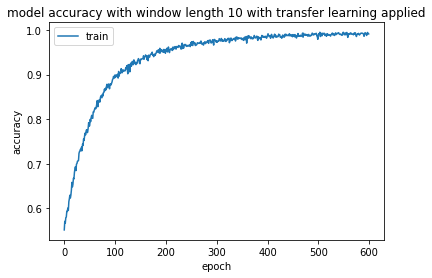

In [0]:
plt.plot(train_accs)
plt.title('model accuracy with window length 10 with transfer learning applied')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

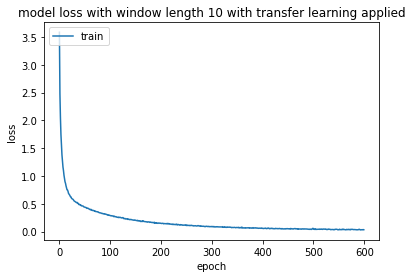

In [0]:
plt.plot(train_losses)
plt.title('model loss with window length 10 with transfer learning applied')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [0]:
base_model.reset_states()
test_results = calc_pos_neg_rate(base_model.evaluate(x=test_generator, verbose=0))

In [0]:
base_model.reset_states()
train_results = calc_pos_neg_rate(base_model.evaluate(x=train_generator, verbose=0))

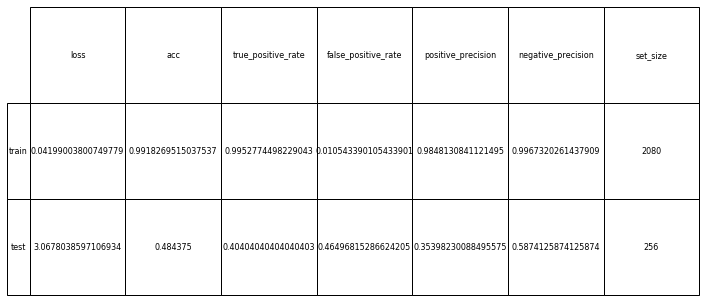

In [0]:
tabular_test_train_results(train_generator, test_generator, train_results, test_results)

**Now, let's compare this model with the model trained from scratch.**

In [0]:
train_start = pandas.to_datetime('20070101', format='%Y%m%d', errors='ignore')
train_end = pandas.to_datetime('20160719', format='%Y%m%d', errors='ignore')
test_start = pandas.to_datetime('20170101', format='%Y%m%d', errors='ignore')
test_end = pandas.to_datetime('20180101', format='%Y%m%d', errors='ignore')
epochs = 5000

First of all, let's visualize the new training set again.

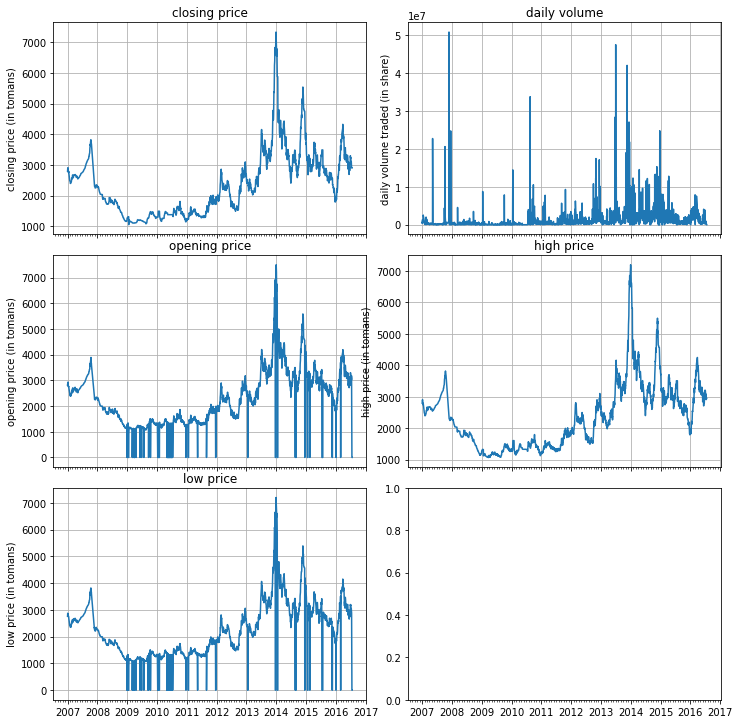

In [0]:
draw_ochlv(data_related_to_second, train_start, train_end)

In [0]:
train_generator, test_generator = generate_datasets_for_model(data, labels, stock_with_second_max_trading_days, train_start, train_end, test_start, test_end)

In [0]:

layers = [
          # input_shape : batch_size, time_step, #features
          LSTM(300, batch_input_shape=(32,train_generator.dim[1], train_generator.dim[2]), stateful=True),
          Dense(84, activation='relu'),
          Dense(1),
          Activation('sigmoid')
         ]


metrics = [BinaryAccuracy(name='accuracy'), TruePositives(name='true_positives'), FalsePositives(name='false_positives'), TrueNegatives(name='true_negatives'), FalseNegatives(name='false_negatives')]
model = build_model(None, optimizer, layers, metrics=metrics)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (32, 300)                 367200    
_________________________________________________________________
dense_8 (Dense)              (32, 84)                  25284     
_________________________________________________________________
dense_9 (Dense)              (32, 1)                   85        
_________________________________________________________________
activation_4 (Activation)    (32, 1)                   0         
Total params: 392,569
Trainable params: 392,569
Non-trainable params: 0
_________________________________________________________________


In [0]:
train_accs, train_losses = fit(model, epochs, train_generator)

epoch 1
----------->> Epoch 1/1   1.703 seconds , loss : 0.693    accuracy : 0.547    
epoch 2
----------->> Epoch 1/1   0.294 seconds , loss : 0.686    accuracy : 0.577    
epoch 3
----------->> Epoch 1/1   0.287 seconds , loss : 0.685    accuracy : 0.555    
epoch 4
----------->> Epoch 1/1   0.289 seconds , loss : 0.674    accuracy : 0.563    
epoch 5
----------->> Epoch 1/1   0.312 seconds , loss : 0.675    accuracy : 0.570    
epoch 6
----------->> Epoch 1/1   0.280 seconds , loss : 0.672    accuracy : 0.566    
epoch 7
----------->> Epoch 1/1   0.285 seconds , loss : 0.670    accuracy : 0.566    
epoch 8
----------->> Epoch 1/1   0.286 seconds , loss : 0.673    accuracy : 0.552    
epoch 9
----------->> Epoch 1/1   0.289 seconds , loss : 0.670    accuracy : 0.560    
epoch 10
----------->> Epoch 1/1   0.294 seconds , loss : 0.667    accuracy : 0.563    
epoch 11
----------->> Epoch 1/1   0.286 seconds , loss : 0.665    accuracy : 0.580    
epoch 12
----------->> Epoch 1/1   0.319 

----------->> Epoch 1/1   0.392 seconds , loss : 0.460    accuracy : 0.766    
epoch 187
----------->> Epoch 1/1   0.305 seconds , loss : 0.470    accuracy : 0.754    
epoch 188
----------->> Epoch 1/1   0.314 seconds , loss : 0.455    accuracy : 0.754    
epoch 189
----------->> Epoch 1/1   0.296 seconds , loss : 0.461    accuracy : 0.757    
epoch 190
----------->> Epoch 1/1   0.308 seconds , loss : 0.465    accuracy : 0.759    
epoch 191
----------->> Epoch 1/1   0.302 seconds , loss : 0.460    accuracy : 0.764    
epoch 192
----------->> Epoch 1/1   0.292 seconds , loss : 0.450    accuracy : 0.775    
epoch 193
----------->> Epoch 1/1   0.300 seconds , loss : 0.490    accuracy : 0.754    
epoch 194
----------->> Epoch 1/1   0.296 seconds , loss : 0.461    accuracy : 0.768    
epoch 195
----------->> Epoch 1/1   0.298 seconds , loss : 0.456    accuracy : 0.760    
epoch 196
----------->> Epoch 1/1   0.302 seconds , loss : 0.450    accuracy : 0.768    
epoch 197
----------->> Epoch 1

----------->> Epoch 1/1   0.291 seconds , loss : 0.266    accuracy : 0.874    
epoch 371
----------->> Epoch 1/1   0.288 seconds , loss : 0.251    accuracy : 0.886    
epoch 372
----------->> Epoch 1/1   0.292 seconds , loss : 0.254    accuracy : 0.878    
epoch 373
----------->> Epoch 1/1   0.293 seconds , loss : 0.264    accuracy : 0.872    
epoch 374
----------->> Epoch 1/1   0.289 seconds , loss : 0.262    accuracy : 0.875    
epoch 375
----------->> Epoch 1/1   0.288 seconds , loss : 0.267    accuracy : 0.882    
epoch 376
----------->> Epoch 1/1   0.291 seconds , loss : 0.280    accuracy : 0.872    
epoch 377
----------->> Epoch 1/1   0.285 seconds , loss : 0.266    accuracy : 0.878    
epoch 378
----------->> Epoch 1/1   0.287 seconds , loss : 0.265    accuracy : 0.882    
epoch 379
----------->> Epoch 1/1   0.286 seconds , loss : 0.267    accuracy : 0.873    
epoch 380
----------->> Epoch 1/1   0.290 seconds , loss : 0.271    accuracy : 0.868    
epoch 381
----------->> Epoch 1

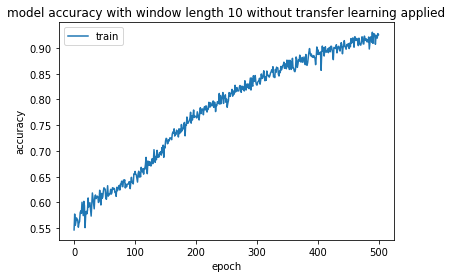

In [0]:
plt.plot(train_accs)
plt.title('model accuracy with window length 10 without transfer learning applied')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

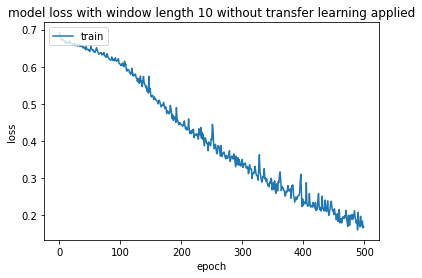

In [0]:
plt.plot(train_losses)
plt.title('model loss with window length 10 without transfer learning applied')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [0]:
model.reset_states()
test_results = calc_pos_neg_rate(model.evaluate(x=test_generator, verbose=0))

In [0]:
model.reset_states()
train_results = calc_pos_neg_rate(model.evaluate(x=train_generator, verbose=0))

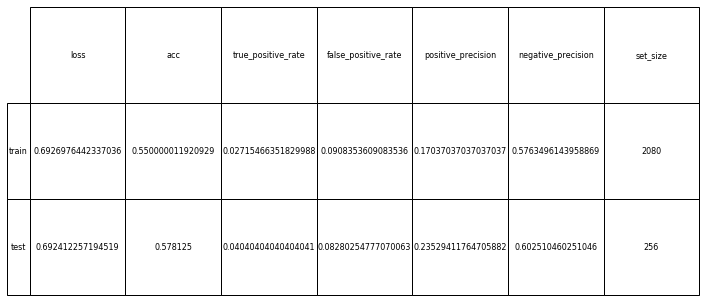

In [0]:
tabular_test_train_results(train_generator, test_generator, train_results, test_results)